In [53]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [54]:
!pip install -q findspark

In [55]:
import os 
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [56]:
import findspark
findspark.init()

In [5]:
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [57]:
import glob
import pandas as pd
import re 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import *

In [58]:
df = spark.read.csv('/content/Property_Assessment_and_Sales_-_FY21.csv')

In [59]:
df.show()

+----+---------+---------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+--------------------+------------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+--------------+-----------------+--------------------+--------------------+-------------+---------------+
| _c0|      _c1|      _c2|       _c3|                 _c4|                 _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|       _c12|                _c13|        _c14|   _c15|               _c16|                _c17|                _c18|                _c19|                _c20|                _c21|                _c22|              _c23|               _c24|      

In [60]:
list_rows= df.collect()
header_values = []
for i in range(len(df.columns)):
  header_values.append(list_rows[0][i])
df = df.toDF(*header_values)
df = df.where(df.LRSN != "LRSN")

In [61]:
df.show()

+----+---------+---------+----------+--------------------+--------------------+----------------------+-----------------------------+-------------------------+--------------------+--------------------+----------------------+-----------+--------------------+------------+-------+-------------------+--------------------------+--------------------+--------------------------------+------------------------+----------------------+-------------------------+------------------+-------------------+--------------+-----------------+--------------------+--------------------+-------------+---------------+
|LRSN|Parcel ID|Extension|      GPIN|   Legal Description|               Owner|Property Street Number|Property Street Number Suffix|Property Street Direction|Property Street Name|Property Street Type|Property Street Suffix|Unit Number|       Property City|Property Zip|Acreage|Land Square Footage|Property Class Description|        Property Use|Residential Finished Living Area|Commercial Building Area|

In [62]:
df.printSchema()

root
 |-- LRSN: string (nullable = true)
 |-- Parcel ID: string (nullable = true)
 |-- Extension: string (nullable = true)
 |-- GPIN: string (nullable = true)
 |-- Legal Description: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Property Street Number: string (nullable = true)
 |-- Property Street Number Suffix: string (nullable = true)
 |-- Property Street Direction: string (nullable = true)
 |-- Property Street Name: string (nullable = true)
 |-- Property Street Type: string (nullable = true)
 |-- Property Street Suffix: string (nullable = true)
 |-- Unit Number: string (nullable = true)
 |-- Property City: string (nullable = true)
 |-- Property Zip: string (nullable = true)
 |-- Acreage: string (nullable = true)
 |-- Land Square Footage: string (nullable = true)
 |-- Property Class Description: string (nullable = true)
 |-- Property Use: string (nullable = true)
 |-- Residential Finished Living Area: string (nullable = true)
 |-- Commercial Building Area: string

In [63]:
print("No:of Rows = ",df.count(), "No:of Columns =",len(df.columns))

No:of Rows =  74767 No:of Columns = 31


In [65]:
df = df.drop(*("Property Street Suffix","Commercial Building Area","Property Street Number Suffix","Unit Number"))

In [66]:
list1 = ["Consideration","Extension","Property Zip","Acreage","Land Square Footage","Residential Finished Living Area","Current Improvement Value","Current Land Value","Current Total Value"]
for i in list1:
  df = df.withColumn(i,df[i].cast('float'))

In [67]:
df.printSchema()

root
 |-- LRSN: string (nullable = true)
 |-- Parcel ID: string (nullable = true)
 |-- Extension: float (nullable = true)
 |-- GPIN: string (nullable = true)
 |-- Legal Description: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- Property Street Number: string (nullable = true)
 |-- Property Street Direction: string (nullable = true)
 |-- Property Street Name: string (nullable = true)
 |-- Property Street Type: string (nullable = true)
 |-- Property City: string (nullable = true)
 |-- Property Zip: float (nullable = true)
 |-- Acreage: float (nullable = true)
 |-- Land Square Footage: float (nullable = true)
 |-- Property Class Description: string (nullable = true)
 |-- Property Use: string (nullable = true)
 |-- Residential Finished Living Area: float (nullable = true)
 |-- Improvement Year Built: string (nullable = true)
 |-- Current Improvement Value: float (nullable = true)
 |-- Current Land Value: float (nullable = true)
 |-- Current Total Value: float (nullable

In [68]:
df.show()

+----+---------+---------+----------+--------------------+--------------------+----------------------+-------------------------+--------------------+--------------------+--------------------+------------+-------+-------------------+--------------------------+--------------------+--------------------------------+----------------------+-------------------------+------------------+-------------------+--------------+-----------------+--------------------+--------------------+-------------+---------------+
|LRSN|Parcel ID|Extension|      GPIN|   Legal Description|               Owner|Property Street Number|Property Street Direction|Property Street Name|Property Street Type|       Property City|Property Zip|Acreage|Land Square Footage|Property Class Description|        Property Use|Residential Finished Living Area|Improvement Year Built|Current Improvement Value|Current Land Value|Current Total Value|Effective Year|    Transfer Date|             Grantor|             Grantee|Consideration|Doc

In [69]:
df.na.fill(value=0)


DataFrame[LRSN: string, Parcel ID: string, Extension: float, GPIN: string, Legal Description: string, Owner: string, Property Street Number: string, Property Street Direction: string, Property Street Name: string, Property Street Type: string, Property City: string, Property Zip: float, Acreage: float, Land Square Footage: float, Property Class Description: string, Property Use: string, Residential Finished Living Area: float, Improvement Year Built: string, Current Improvement Value: float, Current Land Value: float, Current Total Value: float, Effective Year: string, Transfer Date: string, Grantor: string, Grantee: string, Consideration: float, Document Number: string]

In [70]:
df_mean = df.fillna(value=0, subset=['Acreage']).select(mean(col('Acreage')).alias('avg')).collect()
avg = df_mean[0]['avg']
df = df.fillna(value=avg, subset=['Acreage'])

In [92]:
mean2 = df.fillna(value=0, subset=['Land Square Footage']).select(mean(col('Land Square Footage')).alias('avg')).collect()
avg2 = mean2[0]['avg']
df = df.fillna(value=avg2, subset=['Land Square Footage'])

In [93]:
mean3 = df.fillna(value=0, subset=['Residential Finished Living Area']).select(mean(col('Residential Finished Living Area')).alias('avg')).collect()
avg3 = mean3[0]['avg']
df = df.fillna(value=avg3, subset=['Residential Finished Living Area'])

In [94]:
mean4 = df.fillna(value=0, subset=['Current Improvement Value']).select(mean(col('Current Improvement Value')).alias('avg')).collect()
avg4 = mean4[0]['avg']
df = df.fillna(value=avg4, subset=['Current Improvement Value'])

In [95]:
mean5 = df.fillna(value=0, subset=['Current Land Value']).select(mean(col('Current Land Value')).alias('avg')).collect()
avg5 = mean5[0]['avg']
df = df.fillna(value=avg5, subset=['Current Land Value'])

In [75]:
mean6 = df.fillna(value=0, subset=['Current Total Value']).select(mean(col('Current Total Value')).alias('avg')).collect()
avg6 = mean6[0]['avg']
df = df.fillna(value=avg6, subset=['Current Total Value'])

In [96]:
mean7 = df.fillna(value=0, subset=['Consideration']).select(mean(col('Consideration')).alias('avg')).collect()
avg7 = mean7[0]['avg']
df = df.fillna(value=avg7, subset=['Consideration'])

In [97]:
avg8 = 23503
df = df.fillna(value=avg7, subset=['Property Zip'])

In [98]:
df.select("Property Use").groupBy('Property Use').agg(count('Property Use').alias('Count')).orderBy('Count', ascending = False).show()

+--------------------+-----+
|        Property Use|Count|
+--------------------+-----+
|Single Family - D...|46533|
|         Vacant Land| 6060|
|         Non-Taxable| 5001|
|         Condominium| 4814|
|              Duplex| 3673|
|          Commercial| 2972|
|Single Family - A...| 2397|
|           Apartment| 1254|
|          Industrial|  915|
|            Fourplex|  629|
|             Triplex|  316|
|Residential Outbu...|  115|
|         Residential|   65|
|               Co-op|   23|
+--------------------+-----+



In [99]:
df.groupBy("Property Use").sum("Current Total Value").show(truncate=False)

+------------------------+------------------------+
|Property Use            |sum(Current Total Value)|
+------------------------+------------------------+
|Apartment               |5.4993677E9             |
|Vacant Land             |2.9358310477513313E8    |
|Residential Outbuilding |1.18368E7               |
|Non-Taxable             |3.670864975396893E10    |
|Single Family - Detached|1.083399930358135E10    |
|Fourplex                |1.784406E8              |
|Industrial              |4.5256758E9             |
|Condominium             |1.070321008356483E9     |
|Co-op                   |3.49052E7               |
|Single Family - Attached|5.092916E8              |
|Triplex                 |8.77196E7               |
|Commercial              |8.270110021193783E9     |
|Duplex                  |7.399536023875666E8     |
|Residential             |1086200.0               |
+------------------------+------------------------+



In [100]:
df.groupBy("Property Use").sum("Acreage").show(truncate=False)

+------------------------+------------------+
|Property Use            |sum(Acreage)      |
+------------------------+------------------+
|Apartment               |2302.4136376343668|
|Vacant Land             |4733.682242286974 |
|Residential Outbuilding |92.34781332686543 |
|Non-Taxable             |67035.77548313746 |
|Single Family - Detached|38844.460168861784|
|Fourplex                |537.0365119688213 |
|Industrial              |12508.678445462137|
|Condominium             |5751.268095440231 |
|Co-op                   |18.853666752576828|
|Single Family - Attached|1840.0639253193513|
|Triplex                 |268.1626062616706 |
|Commercial              |6789.640753829852 |
|Duplex                  |3322.483817966655 |
|Residential             |81.78012990951538 |
+------------------------+------------------+



In [101]:
 df.groupBy("Property Zip").sum("Current Total Value").show()


+------------+------------------------+
|Property Zip|sum(Current Total Value)|
+------------+------------------------+
|     23503.0|     5.683800047751331E8|
|     23518.0|    1.866107330435648E10|
|     23517.0|              5.302109E8|
|     23508.0|              9.473888E8|
|     23507.0|              2.690355E8|
|     23501.0|              2.597791E8|
|     23504.0|    3.8818740477513313E8|
|     23510.0|    1.4698185035813498E9|
|2.35186112E8|                402700.0|
|   1.1937833|    4.384216266358134...|
|     23509.0|     5.615010119378328E7|
|     23523.0|               2.38216E8|
|    235010.0|                319800.0|
|     23514.0|                 52500.0|
|     23502.0|            6.11597912E8|
|     23513.0|              3.819522E8|
|     23505.0|              4.936762E8|
|2.35182944E8|                311600.0|
|     22508.0|                239300.0|
| 2.3504352E8|                255200.0|
+------------+------------------------+
only showing top 20 rows



In [113]:
 S=df.groupBy("Property Zip").sum("Acreage").show()

+------------+------------------+
|Property Zip|      sum(Acreage)|
+------------+------------------+
|     23503.0| 1152.521847535856|
|     23518.0| 41020.63060762081|
|     23517.0| 435.4383842088282|
|     23508.0| 816.1092338059098|
|     23507.0| 327.8525056615472|
|     23501.0|392.93957706168294|
|     23504.0|2032.6294511277229|
|     23510.0| 906.2667731158435|
|2.35186112E8|1.1937832832336426|
|   1.1937833| 93466.17008749035|
|     23509.0| 460.9308999441564|
|     23523.0| 798.8600652590394|
|    235010.0| 0.734499990940094|
|     23514.0| 2.387566566467285|
|     23502.0| 927.8784486297518|
|     23513.0| 708.8521633464843|
|     23505.0| 634.9380050105974|
|2.35182944E8|0.6545000076293945|
|     22508.0|1.1937832832336426|
| 2.3504352E8|1.1937832832336426|
+------------+------------------+
only showing top 20 rows



In [103]:
df.groupBy("Property Zip").sum("Current Land Value").show()

+------------+-----------------------+
|Property Zip|sum(Current Land Value)|
+------------+-----------------------+
|     23503.0|   1.8520210477513313E8|
|     23518.0|     6.50096917635648E9|
|     23517.0|              8.27919E7|
|     23508.0|             2.332065E8|
|     23507.0|              4.06158E7|
|     23501.0|               9.4052E7|
|     23504.0|   1.1493890477513313E8|
|     23510.0|   2.2676420358134985E8|
|2.35186112E8|               149000.0|
|   1.1937833|   1.417048109958134...|
|     23509.0|   2.7870201193783283E7|
|     23523.0|              9.28885E7|
|    235010.0|               319800.0|
|     23514.0|                52500.0|
|     23502.0|             1.513087E8|
|     23513.0|              7.78199E7|
|     23505.0|             1.265204E8|
|2.35182944E8|                92700.0|
|     22508.0|               239300.0|
| 2.3504352E8|                39000.0|
+------------+-----------------------+
only showing top 20 rows



The Visualization part is done by using pandas seaborn and matpolylib

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [108]:
df1 = pd.read_csv('Property_Assessment_and_Sales_-_FY21.csv')

In [110]:
mean = df1['Acreage'].mean()
df1['Acreage'].fillna(value=mean, inplace=True)

In [111]:
mean1 = df1['Land Square Footage'].mean()
df1['Land Square Footage'].fillna(value=mean1, inplace=True)

In [115]:
mean2 = df1['Residential Finished Living Area'].mean()
df1['Residential Finished Living Area'].fillna(value=mean2, inplace=True)

In [116]:
mean3 = df1['Commercial Building Area'].mean()
df1['Commercial Building Area'].fillna(value=mean3, inplace=True)

In [117]:
mean4 = df1['Current Improvement Value'].mean()
df1['Current Improvement Value'].fillna(value=mean4, inplace=True)

In [118]:
mean5 = df1['Current Land Value'].mean()
df1['Current Land Value'].fillna(value=mean5, inplace=True)

In [119]:
mean6 = df1['Current Total Value'].mean()
df1['Current Total Value'].fillna(value=mean6, inplace=True)

In [120]:
mean7 = df1['Consideration'].mean()
df1['Consideration'].fillna(value=mean7, inplace=True)

In [122]:
zip_re = 23503
df1['Property Zip'].fillna(value=zip_re,inplace=True)

In [123]:
df1['zip_code']=df1['Property Zip'].str[:5]

,LRSN,Parcel ID,Extension,GPIN,Legal Description,Owner,Property Street Number,Property Street Number Suffix,Property Street Direction,Property Street Name,...,Current Improvement Value,Current Land Value,Current Total Value,Effective Year,Transfer Date,Grantor,Grantee,Consideration,Document Number,zip_code
0,8,11605.0,C01,1.448672e+09,D Simpson Farm,A A A Of Norfolk Inc,3044.0,,,Sewells Point,...,4439400.0,822600.0,5262000.0,July 01 2020,July 10 1972,NaN,A A A Of Norfolk Inc,64000.0,,23513
1,9,11630.0,C01,1.437082e+09,21 Ft,Seven Thirtyone Monticello Av Llc,731.0,,,Monticello,...,129400.0,57200.0,186600.0,July 01 2020,December 08 1995,NaN,Seven Thirtyone Monticello Av Llc,80000.0,,23510


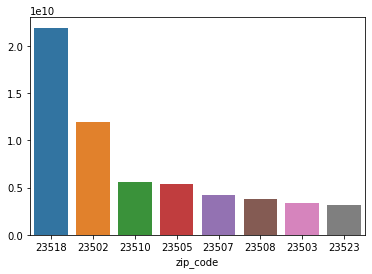

In [125]:
Zip_Value = df1.groupby('zip_code')['Current Total Value'].sum().nlargest(8)
sns.barplot(x = Zip_Value.index, y = Zip_Value.values)

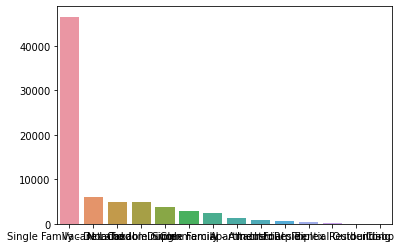

In [126]:
pro_count = df1['Property Use'].value_counts()
sns.barplot(x = pro_count.index, y = pro_count.values)
sns.set(rc = {'figure.figsize':(15,20)})

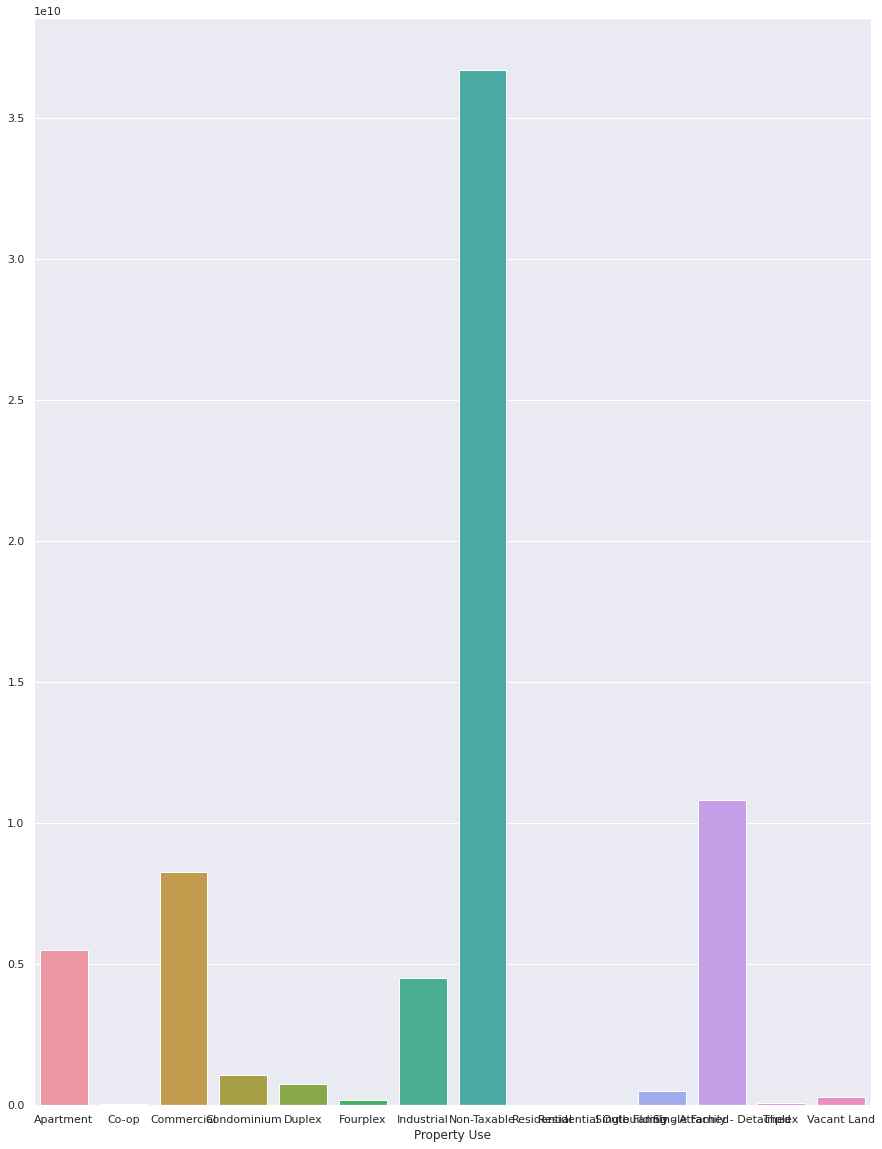

In [131]:
pro_value = df1.groupby('Property Use')['Current Total Value'].sum()
sns.barplot(x = pro_value.index, y = pro_value.values)

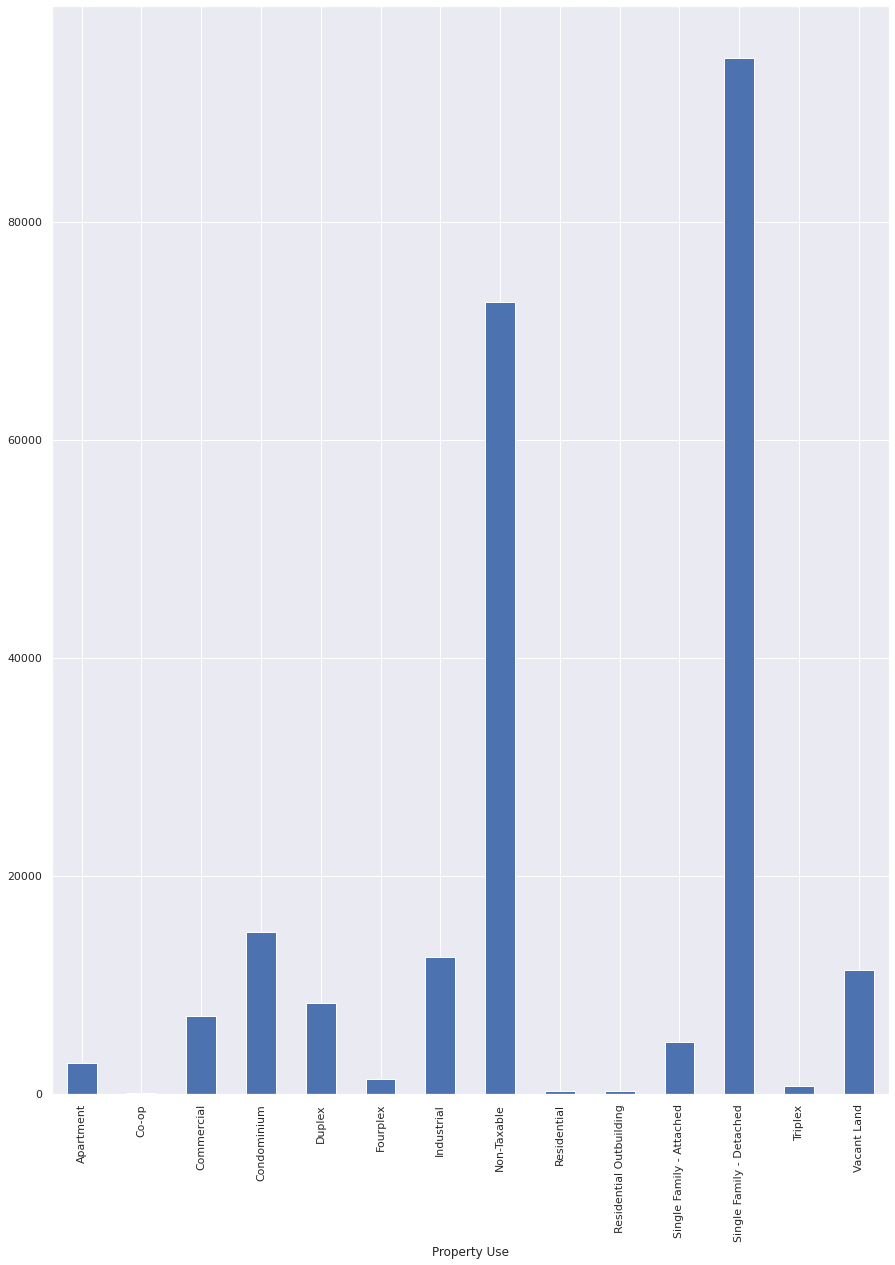

In [132]:
df1.groupby('Property Use')['Acreage'].sum().plot(kind='bar')

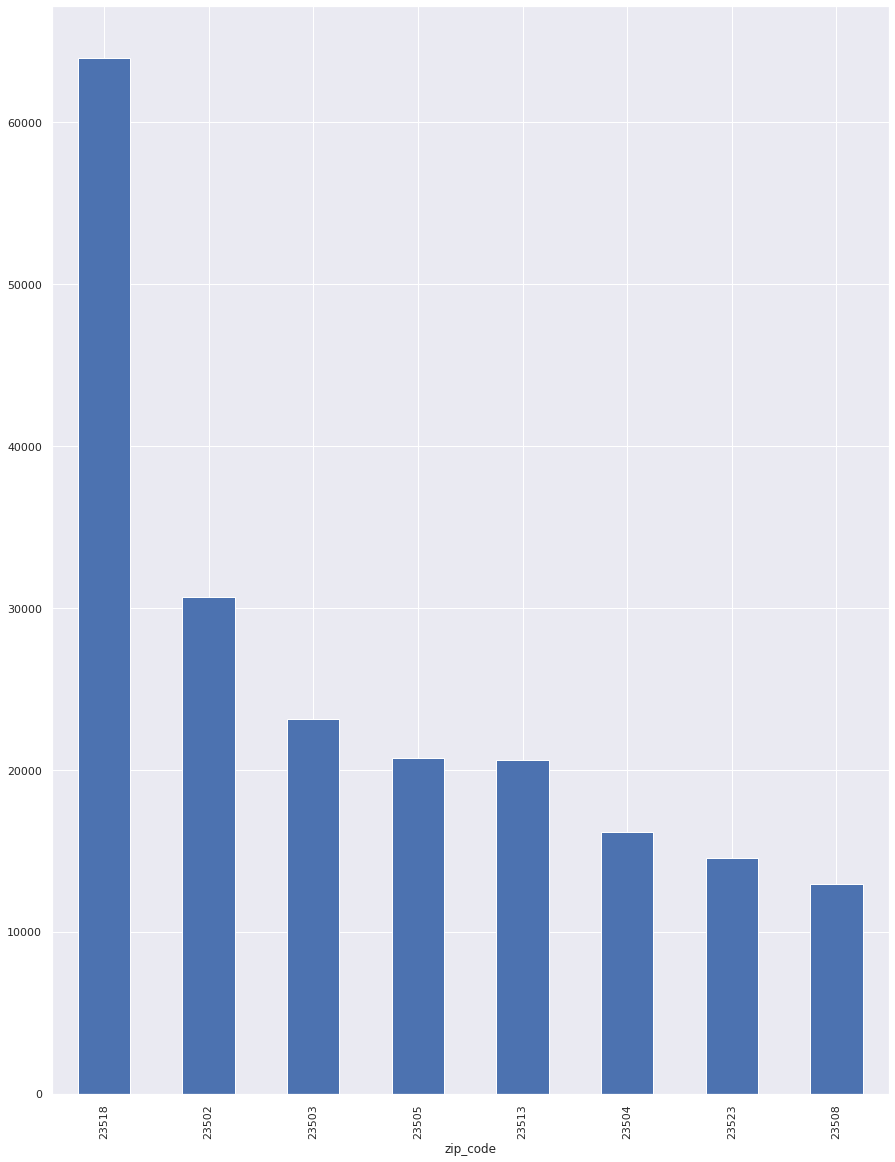

In [133]:
df1.groupby('zip_code')['Acreage'].sum().nlargest(8).plot(kind = 'bar')

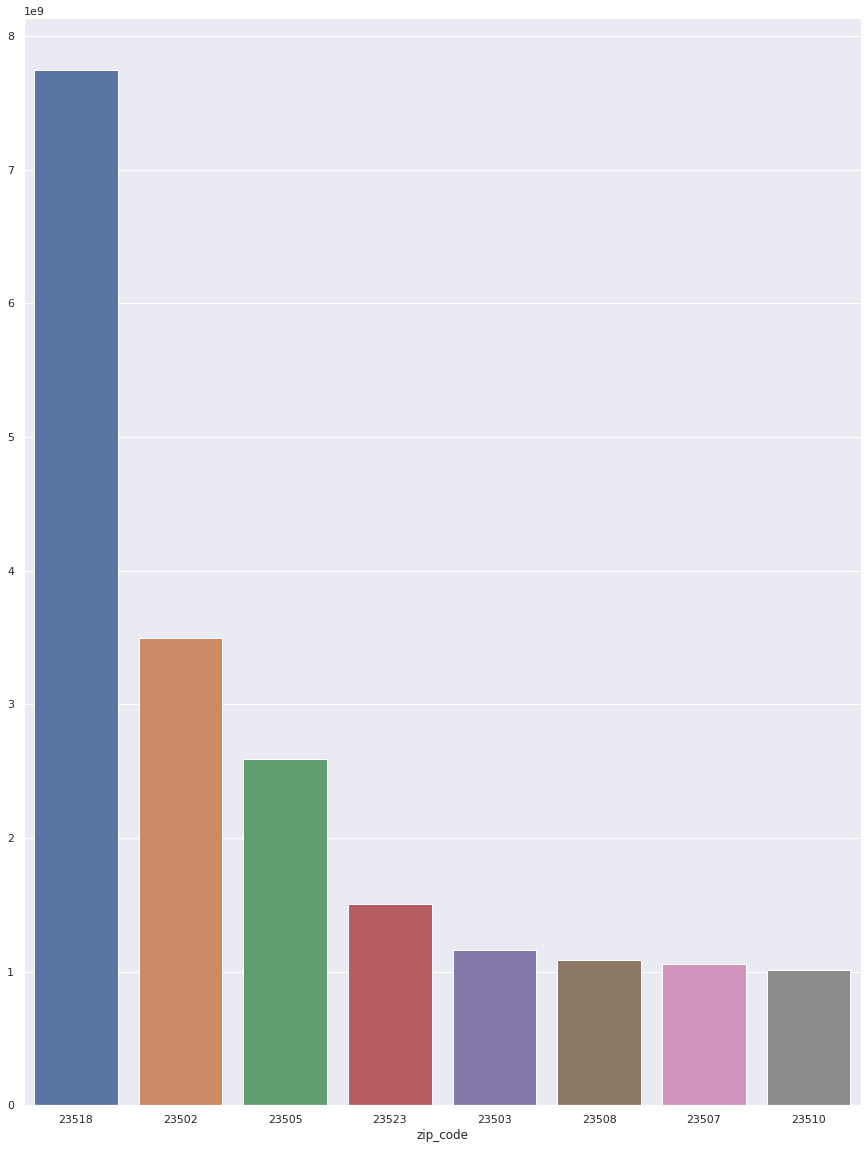

In [134]:
zip_land_value = df1.groupby('zip_code')['Current Land Value'].sum().nlargest(8)
sns.barplot(x = zip_land_value.index, y = zip_land_value.values)
sns.set(rc = {'figure.figsize':(15,20)})

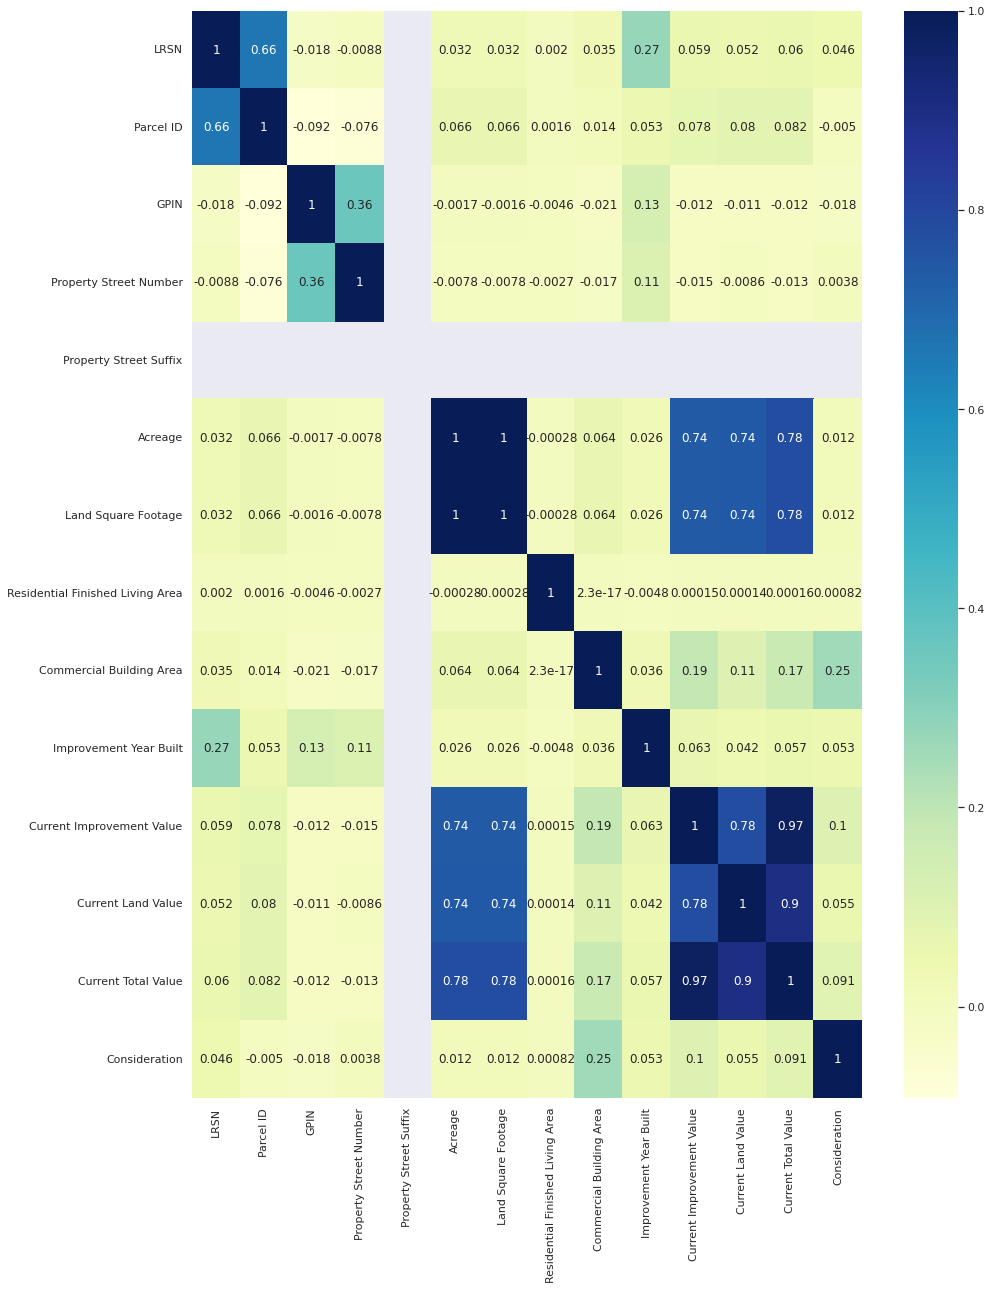

In [136]:
sns.heatmap(df1.corr(), cmap="YlGnBu", annot=True)